# Create daily global netcdfs of CHLA(z)

```{important}
This notebook requires zarr version 3+!
```

This walks through the logic. The actual code was run on Dask Gateway cluster and is in `pipeline_chla_z.ipynb`. The code to create the BRT model is in `BRT_CHLA_z.ipynb`.

[Video of me walking through this notebook](https://youtu.be/TvUocPi98TY)

The workflow is

* Get Rrs data (predictors) from PACE
* Make prediction using predictors and BRT model
* Build CHLA(z) xarray DataSet
* Add on derived metrics like depth of peak to the DataSet
* Save a netcdf file to google cloud bucket

In [1]:
# --- Core data handling and plotting libraries ---
import earthaccess
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import pandas as pd
import matplotlib.pyplot as plt  # for creating plots
import cartopy.crs as ccrs
import sklearn
# --- Custom python functions ---
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)
# core stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.ndimage import uniform_filter1d

## Read in model

In [12]:
## Load model
bundle = mu.load_ml_bundle("models/brt_chla_profiles_bundle.zip")


Loaded ML bundle from: models/brt_chla_profiles_bundle.zip
  model_kind : pickle
  model_type : collection (dict), n_submodels=20
  example key: CHLA_0_10
  target     : log10_CHLA_A_B depth bins
  features   : 174 columns
  train/test : 4408 / 1102 rows
  dataset    : 5510 rows stored in bundle

Usage example (Python):
  bundle = load_ml_bundle('path/to/bundle.zip')
  # Predict using helper 'predict_all_depths_for_day'
  # Example: predict all depths for one day from a BRF dataset R
  pred = bundle.predict(
      R_dataset,                  # xr.DataArray/xr.Dataset with lat/lon + predictors
      brt_models=bundle.model,    # dict of models by depth bin
      feature_cols=bundle.meta['feature_cols'],
      consts={'solar_hour': 12.0, 'type': 1},
  )  # -> e.g. CHLA(time?, z, lat, lon)

  # Plot using helper 'make_plot_pred_map'
  fig, ax = bundle.plot(pred_da, pred_label='Prediction')



## Create a dataset with our variables derived from CHLA(z)

In [3]:
import xarray as xr
import numpy as np

def build_chla_profile_dataset(CHLA: xr.DataArray) -> xr.Dataset:
    """
    Given CHLA(time, z, lat, lon) on linear not log10 scale, compute derived metrics and
    return an xr.Dataset suitable for writing to Zarr/NetCDF.
    """

    # Start from CHLA's own dataset so its coords (including z_start/z_end) win
    ds = CHLA.to_dataset(name="CHLA")

    # ---- Layer thickness (z dimension) ----
    z_start = CHLA.coords.get("z_start", None)
    z_end   = CHLA.coords.get("z_end", None)

    if (z_start is not None) and (z_end is not None):
        z_thick = (z_end - z_start).rename("z_thickness")   # (z)
    else:
        # fallback: uniform layer thickness, e.g. 10 m
        z_thick = xr.full_like(CHLA["z"], 10.0).rename("z_thickness")

    z_center = CHLA["z"]

    # total CHLA in column (used for validity + center-of-mass)
    col_total = CHLA.sum("z")          # (time, lat, lon)
    valid = col_total > 0              # True where there is some CHLA

    # ---- Integrated CHLA (nominal 0–200 m; actual range = z extent) ----
    CHLA_int = (CHLA * z_thick).sum("z")
    CHLA_int = CHLA_int.where(valid)
    CHLA_int.name = "CHLA_int_0_200"

    # ---- Peak value and depth (NaN-safe) ----
    CHLA_filled = CHLA.fillna(-np.inf)
    peak_idx = CHLA_filled.argmax("z")       # (time, lat, lon) integer indices

    CHLA_peak = CHLA.isel(z=peak_idx).where(valid)
    CHLA_peak.name = "CHLA_peak"

    CHLA_peak_depth = z_center.isel(z=peak_idx).where(valid)
    CHLA_peak_depth.name = "CHLA_peak_depth"

    # ---- Depth-weighted mean depth (center of mass) ----
    num = (CHLA * z_center).sum("z")
    den = col_total
    depth_cm = (num / den).where(valid)
    depth_cm.name = "CHLA_depth_center_of_mass"

    # ---- Attach derived fields to the dataset ----
    ds["CHLA_int_0_200"] = CHLA_int
    ds["CHLA_peak"] = CHLA_peak
    ds["CHLA_peak_depth"] = CHLA_peak_depth
    ds["CHLA_depth_center_of_mass"] = depth_cm
    ds["z_thickness"] = z_thick

    # ---- Variable attributes ----
    # CHLA itself should already have attrs from the prediction step
    ds["CHLA"].attrs.setdefault("units", "mg m-3")
    ds["CHLA"].attrs.setdefault("long_name", "Chlorophyll-a concentration")
    ds["CHLA"].attrs.setdefault(
        "description",
        "BRT-derived chlorophyll-a profiles from PACE hyperspectral Rrs",
    )

    ds["CHLA_int_0_200"].attrs.update(
        units="mg m-2",
        long_name="Depth-integrated chlorophyll-a",
        description=(
            "Vertical integral of CHLA over the available depth bins "
            "(nominally 0–200 m; actual range defined by z_start/z_end)."
        ),
    )

    ds["CHLA_peak"].attrs.update(
        units="mg m-3",
        long_name="Peak chlorophyll-a concentration in the water column",
        description="Maximum CHLA value over depth at each (time, lat, lon).",
    )

    ds["CHLA_peak_depth"].attrs.update(
        units="m",
        long_name="Depth of peak chlorophyll-a",
        positive="down",
        description=(
            "Depth (bin center) where CHLA is maximal in the water column "
            "at each (time, lat, lon)."
        ),
    )

    ds["CHLA_depth_center_of_mass"].attrs.update(
        units="m",
        long_name="Chlorophyll-a depth center of mass",
        positive="down",
        description=(
            "Depth of the chlorophyll-a center of mass, computed as "
            "sum_z(CHLA * z) / sum_z(CHLA)."
        ),
    )

    ds["z_thickness"].attrs.update(
        units="m",
        long_name="Layer thickness",
        description=(
            "Thickness of each vertical bin used for depth integration. "
            "Derived from z_end - z_start when available; otherwise set to a "
            "uniform nominal thickness."
        ),
    )

    # You can still add global ds.attrs later in your pipeline
    return ds

## Pipeline bits

* Get Rrs data (predictors) from PACE
* Make prediction using predictors and BRT model
* Build CHLA(z) xarray DataSet
* Add on derived metrics like depth of peak to the DataSet
* Save a netcdf file to google cloud bucket

In [13]:
%%time
# Get some Rrs data
import earthaccess
import xarray as xr

day = "2024-07-08"

auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

# Get Rrs
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    temporal = (day, day),
    granule_name="*.DAY.*.4km.nc"
)
f = earthaccess.open(rrs_results[0:1], pqdm_kwargs={"disable": True})
rrs_ds = xr.open_dataset(f[0])

CPU times: user 418 ms, sys: 19.6 ms, total: 438 ms
Wall time: 8.62 s


In [14]:
rrs_ds

<xarray.Dataset> Size: 26GB
Dimensions:     (lat: 4320, lon: 8640, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 26GB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240708.L3m.DAY.RRS.V3_1.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3392806
    data_minimum:                      -0.009998
    data_maximum:                      0.09845579

In [15]:
%%time
# Create predictions for small region
lat_min, lat_max = 20, 40
lon_min, lon_max = -70, -60
# Get Rrs for that box
R = rrs_ds["Rrs"].sel(
    lat=slice(lat_max, lat_min),   # decreasing lat coord: max→min
    lon=slice(lon_min, lon_max)
)
pred = bundle.predict(
      R,                  # xr.DataArray/xr.Dataset with lat/lon + predictors
      brt_models=bundle.model,    # dict of models by depth bin
      feature_cols=bundle.meta['feature_cols'],
      consts={'solar_hour': 0, 'type': 1},
      linear=True # linear not log10 scale
  )
pred

Starting 0 of 480
Starting 100 of 480
Starting 200 of 480
Starting 300 of 480
Starting 400 of 480
Starting wrapping
Adding coords
CPU times: user 8.17 s, sys: 182 ms, total: 8.36 s
Wall time: 8.18 s


<xarray.DataArray 'CHLA' (z: 20, lat: 480, lon: 240)> Size: 9MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.03266423, 0.04069679, 0.03724122, ..., 0.03161198,
         0.03015661, 0.03102249],
        [0.03266423, 0.04069679, 0.03724122, ..., 0.03415953,
         0.03021031, 0.03087335],
        [0.03312938, 0.03150391, 0.03264855, ..., 0.03555167,
         0.03399697, 0.03372457]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.02875154, 0.02663061, 0.02663061, ..., 0.03754199,
         0.03753266, 0.03754199],
        [0.02875154, 0.02663061, 0.02663061, ..., 0.03272235,
         0.03754199, 0.03686153],
        [0.02875154, 0.02875154, 0.02875154, ..., 0.03354362,
         0.03272235, 0.03283684]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.03892992, 0.03904185, 0.03904185, ..., 0.05571457,
         0.05332995, 0.05450997],
        [0.03892992, 0.03904185, 0.03904185, ..., 0.04524755,
         0.05450997, 0.05544097],
        [0.03892992, 0.03892992, 0.03991913, ..., 0.04672984,
         0.04672984, 0.05149535]]], shape=(20, 480, 240), dtype=float32)
Coordinates:
  * lat      (lat) float32 2kB 39.98 39.94 39.9 39.85 ... 20.15 20.1 20.06 20.02
  * lon      (lon) float32 960B -69.98 -69.94 -69.9 ... -60.1 -60.06 -60.02
  * z        (z) float32 80B 5.0 15.0 25.0 35.0 45.0 ... 165.0 175.0 185.0 195.0
    z_start  (z) float32 80B 0.0 10.0 20.0 30.0 40.0 ... 160.0 170.0 180.0 190.0
    z_end    (z) float32 80B 10.0 20.0 30.0 40.0 ... 170.0 180.0 190.0 200.0
Attributes:
    depth_info:  Depth coordinates inferred from brt_models keys of form 'NAM...

In [8]:
# Add metrics 
import tempfile
ds_day = build_chla_profile_dataset(pred)
ds_day

<xarray.Dataset> Size: 11MB
Dimensions:                    (lat: 480, lon: 240, z: 20)
Coordinates:
  * lat                        (lat) float32 2kB 39.98 39.94 ... 20.06 20.02
  * lon                        (lon) float32 960B -69.98 -69.94 ... -60.02
  * z                          (z) float32 80B 5.0 15.0 25.0 ... 185.0 195.0
    z_start                    (z) float32 80B 0.0 10.0 20.0 ... 180.0 190.0
    z_end                      (z) float32 80B 10.0 20.0 30.0 ... 190.0 200.0
Data variables:
    CHLA                       (z, lat, lon) float32 9MB nan nan ... 0.0515
    CHLA_int_0_200             (lat, lon) float32 461kB nan nan ... 17.42 18.82
    CHLA_peak                  (lat, lon) float32 461kB nan nan ... 0.1874
    CHLA_peak_depth            (lat, lon) float32 461kB nan nan ... 95.0 65.0
    CHLA_depth_center_of_mass  (lat, lon) float32 461kB nan nan ... 98.18 99.76
    z_thickness                (z) float32 80B 10.0 10.0 10.0 ... 10.0 10.0 10.0

In [10]:
# Save to a local netcdf
from pathlib import Path
import tempfile
tmp_dir = Path(tempfile.gettempdir())
local_path = tmp_dir / f"chla_z_{day}.nc"
ds_day.to_netcdf(
    local_path,
    engine="h5netcdf",
)
ds_day

<xarray.Dataset> Size: 11MB
Dimensions:                    (lat: 480, lon: 240, z: 20)
Coordinates:
  * lat                        (lat) float32 2kB 39.98 39.94 ... 20.06 20.02
  * lon                        (lon) float32 960B -69.98 -69.94 ... -60.02
  * z                          (z) float32 80B 5.0 15.0 25.0 ... 185.0 195.0
    z_start                    (z) float32 80B 0.0 10.0 20.0 ... 180.0 190.0
    z_end                      (z) float32 80B 10.0 20.0 30.0 ... 190.0 200.0
Data variables:
    CHLA                       (z, lat, lon) float32 9MB nan nan ... 0.0515
    CHLA_int_0_200             (lat, lon) float32 461kB nan nan ... 17.42 18.82
    CHLA_peak                  (lat, lon) float32 461kB nan nan ... 0.1874
    CHLA_peak_depth            (lat, lon) float32 461kB nan nan ... 95.0 65.0
    CHLA_depth_center_of_mass  (lat, lon) float32 461kB nan nan ... 98.18 99.76
    z_thickness                (z) float32 80B 10.0 10.0 10.0 ... 10.0 10.0 10.0

In [11]:
# Test saving a file to the bucket
# Assumes the credentials are in /home/jovyan/.config/gcloud
# stop annoying warnings
# https://console.cloud.google.com/storage/browser/nmfs_odp_nwfsc/CB/fish-pace-datasets
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")

from google.cloud import storage
from pathlib import Path

# === Set these ===
bucket_name = "nmfs_odp_nwfsc"

# Create client and bucket
client = storage.Client(project="noaa-gcs-public-data")
bucket = client.bucket(bucket_name)

# Set the file you want to test with
destination_prefix = "CB/fish-pace-datasets/chla-z/test"

# Create blob and upload
blob_path = f"{destination_prefix}/{local_path.name}"
blob = bucket.blob(blob_path)
blob.upload_from_filename(str(local_path))

print(f"Uploaded {local_path.name} → gs://{bucket_name}/{blob_path}")

# Get rid of the temp file
# this is crucial. Remove file from /tmp when done. Otherwise /tmp will fill and server will crash.
local_path.unlink(missing_ok=True)

Uploaded chla_z_2024-07-08.nc → gs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/test/chla_z_2024-07-08.nc


## Full pipeline in a for loop


In [4]:
# Get Rrs data
import earthaccess
import xarray as xr

auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

# Get Rrs
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    granule_name="*.DAY.*.4km.nc"
)
len(rrs_results)

560

In [ ]:
%%time
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import earthaccess
from google.cloud import storage
import tempfile

# Get Rrs data
import earthaccess
import xarray as xr

auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

# Get Rrs
rrs_results = earthaccess.search_data(
    short_name = "PACE_OCI_L3M_RRS",
    granule_name="*.DAY.*.4km.nc"
)

# === Set these ===
bucket_name = "nmfs_odp_nwfsc"
# Create client and bucket
client = storage.Client(project="noaa-gcs-public-data")
bucket = client.bucket(bucket_name)
destination_prefix = "CB/fish-pace-datasets/chla-z/netcdf"

lat_chunk = 100
lon_chunk = 100

# just test on first two granules
for res in rrs_results[0:1]:
    # day as ISO string from UMM
    day_iso = res["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"]
    day = pd.to_datetime(day_iso)          # Timestamp
    day_str = day.strftime("%Y%m%d")
    print(f"Processing {day_str}...")

    # auth per granule (you can optimize this later if you want)
    auth = earthaccess.login()
    files = earthaccess.open([res], pqdm_kwargs={"disable": True})

    # open dataset
    rrs_ds = xr.open_dataset(files[0])
    # debugging line
    #rrs_ds = rrs_ds.sel(lat=slice(40, 20), lon=slice(-70, -60) )

    try:
        # Rrs for that day
        # (if the file has only one time, squeeze; otherwise select)
        if "time" in rrs_ds.dims:
            R = rrs_ds["Rrs"].sel(time=day).squeeze("time")
        else:
            R = rrs_ds["Rrs"]
        R = R.transpose("lat", "lon", "wavelength")

        # BRT predictions for all depths
        pred = bundle.predict(
            R,
            brt_models=bundle.model,
            feature_cols=bundle.meta["feature_cols"],
            consts={"solar_hour": 0, "type": 1},
            chunk_size_lat=100,
            time=day.to_datetime64(),   # time coord length 1
            z_name="z",
            silent=False,
        )  # (time=1, z, lat, lon), float32

        # Build full dataset with integrated/peak metrics
        ds_day = build_chla_profile_dataset(pred)

        # Add metadata
        ds_day["CHLA"].attrs.update(
            units="mg m-3",
            long_name="Chlorophyll-a concentration",
            description="BRT-derived CHLA profiles from PACE hyperspectral Rrs",
        )
        ds_day["z"].attrs.update(units="m", long_name="depth (bin center)")
        ds_day["lat"].attrs.update(units="degrees_north")
        ds_day["lon"].attrs.update(units="degrees_east")
        ds_day.attrs["source"] = "BRT model trained on BGC-Argo + OOI matchups"
        ds_day.attrs["model_bundle"] = Path("path/to/bundle.zip").name

        # Chunking for NetCDF
        encoding = {
            "CHLA": {
                "dtype": "float32",
                "zlib": True,
                "complevel": 4,
                "chunksizes": (1, ds_day.sizes["z"], lat_chunk, lon_chunk),
            }
            # you can add encodings for derived vars later if desired
        }

        # 4. Write to a local temporary NetCDF, then upload to GCS
        tmp_dir = Path(tempfile.gettempdir())
        local_path = tmp_dir / f"chla_z_{day_str}.nc"
        
        ds_day.to_netcdf(
            local_path,
            engine="h5netcdf",
            encoding=encoding,
        )
        
        blob_path = f"{destination_prefix}/chla_z_{day_str}.nc"
        blob = bucket.blob(blob_path)
        blob.upload_from_filename(str(local_path))
        
        print(f"Wrote {local_path} → gs://{bucket_name}/{blob_path}")
        
    finally:
        rrs_ds.close()
        del ds_day, pred, R, rrs_ds


## Test the netcdf

In [16]:
%%time
import xarray as xr
import gcsfs

fs = gcsfs.GCSFileSystem(token="anon")
pattern = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_*_v2.nc"
paths = ["gcs://" + p for p in sorted(fs.glob(pattern))]
print("files:", len(paths), "first:", paths[0])

# Note if you have your bucket credentials set up in /home/jovyan/.config/gcloud
# you don't need storage_options={"token": 'anon'} for this public bucket, but 
# best to keep in your code so others, without those credentials, also can load
ds = xr.open_mfdataset(
    paths[0:5],
    engine="h5netcdf",
    combine="by_coords",   # uses the time coordinate in each file
    parallel=True,
    chunks={},             # use what is in the file; we'll rechunk explicitly later
    storage_options={"token": 'anon'} # public bucket
)
ds

files: 560 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305_v2.nc
CPU times: user 2.3 s, sys: 405 ms, total: 2.7 s
Wall time: 11.7 s


<xarray.Dataset> Size: 18GB
Dimensions:                    (time: 5, z: 20, lat: 4320, lon: 8640)
Coordinates:
  * time                       (time) datetime64[ns] 40B 2024-03-05 ... 2024-...
  * lat                        (lat) float32 17kB 89.98 89.94 ... -89.94 -89.98
  * lon                        (lon) float32 35kB -180.0 -179.9 ... 179.9 180.0
  * z                          (z) float32 80B 5.0 15.0 25.0 ... 185.0 195.0
    z_start                    (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
    z_end                      (z) float32 80B dask.array<chunksize=(20,), meta=np.ndarray>
Data variables:
    CHLA                       (time, z, lat, lon) float32 15GB dask.array<chunksize=(1, 20, 100, 100), meta=np.ndarray>
    CHLA_int_0_200             (time, lat, lon) float32 746MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    CHLA_peak                  (time, lat, lon) float32 746MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    CHLA_peak_depth            (time, lat, lon) float32 746MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    CHLA_depth_center_of_mass  (time, lat, lon) float32 746MB dask.array<chunksize=(1, 100, 100), meta=np.ndarray>
    z_thickness                (time, z) float32 400B dask.array<chunksize=(1, 20), meta=np.ndarray>

## Creating a Zarr store from these netcdfs

A Zarr store is a cloud native format that allows rapid read to a large (in this case 2Tb) dataset.  Technically, we could do the code below and it is beautifully simple. If our `ds` were small, this would work. But our dataset is like 2Tb and this will take days to run. Hopefully our server never crashes since we have to start from scratch if it does. It will use dask to write in chunks so it won't need vast amounts of RAM, but it will write in serial and be desperately slow.

**But** if your dataset is in the 100s of Mb, then do the below because it is **far simpler** than the parallel processing that I do with Dask Gateway and Zarr region writes.

In [11]:
%%script false --no-raise-error
# This takes a long time
ds = xr.open_mfdataset(
    paths,
    engine="h5netcdf",
    combine="by_coords",   # uses the time coordinate in each file
    parallel=True,
    chunks={},             # use what is in the file; we'll rechunk explicitly later
    storage_options={"token": 'anon'} # public bucket
)

# This steps could take many days
token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
zarr_path = "gs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds.to_zarr(
    zarr_path,
    storage_options={"token": cred_path},
    mode="w",
    consolidated=False,
)

### Writing a Zarr store in parallel

See `pipeline_zarr_store.ipynb` for code.

Basic idea is

1. Write a blank Zarr store that is the right shape to your bucket
2. Write time slices (day in my case) to the store
3. Run on Dask Gateway to run with many workers at the same time. I used 20 and was done in 5 hours.

## Example loading from zarr

CPU times: user 2.29 s, sys: 272 ms, total: 2.56 s
Wall time: 2.9 s


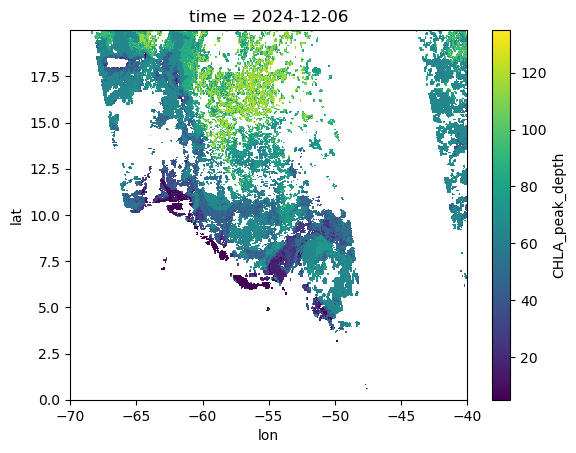

In [1]:
%%time
# requires zarr version 3+
import xarray as xr
i = 263
zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})
ds["CHLA_peak_depth"].isel(time=i).sel(lat=slice(20,0), lon=slice(-70,-40)).plot();

In [ ]:
%%time
# requires zarr version 3+
import xarray as xr
i = 263
zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})
ds["CHLA_peak_depth"].isel(time=i).sel(lat=slice(20,0), lon=slice(-70,-40)).plot();

In [2]:
import gcsfs
# if bucket were private, use this
# token = "/home/jovyan/.config/gcloud/application_default_credentials.json"
# fs = gcsfs.GCSFileSystem(token=token)
fs = gcsfs.GCSFileSystem(token="anon")
# all .nc with _v2
base = "nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf"
all_nc = sorted(fs.glob(f"{base}/chla_z_*.nc"))
paths_v2 = ["gcs://" + p for p in all_nc if "_v2" in p]
print("files:", len(paths_v2), "first:", paths_v2[0])

files: 560 first: gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/netcdf/chla_z_20240305_v2.nc


CPU times: user 494 ms, sys: 120 ms, total: 614 ms
Wall time: 3.92 s


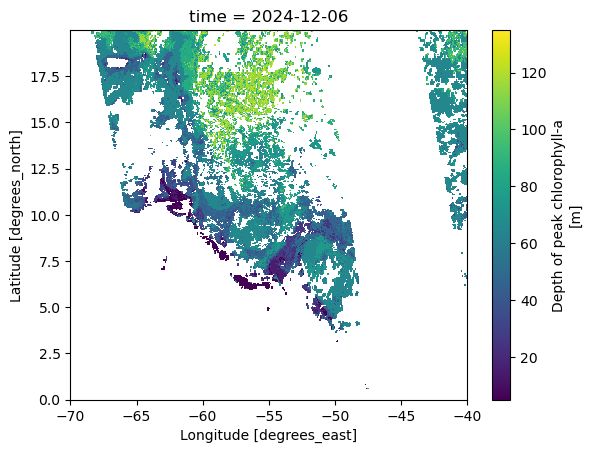

In [6]:
%%time
import xarray as xr
i = 263
ds = xr.open_dataset(
    paths_v2[i],
    engine="h5netcdf",
    storage_options={"token": 'anon'} # public bucket
)
ds["CHLA_peak_depth"].sel(lat=slice(20,0), lon=slice(-70,-40)).plot();

## Why Zarr? Because it is so much faster

This shows two examples of doing a time average. The Zarr workflow is 15x faster and I used an easy example because `xr.open_mfdataset()` is crushingly slow so I had to limit to 5 files. With Zarr, I could open the whole dataset in an instant.

CPU times: user 349 ms, sys: 8.48 ms, total: 357 ms
Wall time: 510 ms


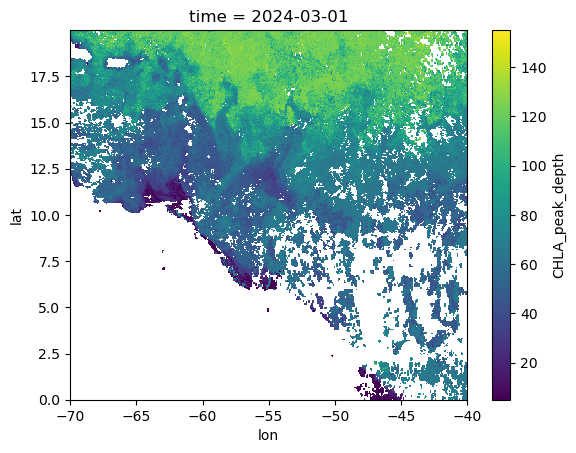

In [31]:
%%time
# Demo: "Monthly mean over a modest ROI" (real workflow)

import xarray as xr

zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})

roi = ds["CHLA_peak_depth"].isel(time=slice(0,5)).sel(lat=slice(20, 0), lon=slice(-70, -40))
m = roi.resample(time="MS").mean("time").compute()
m.isel(time=0).plot();

CPU times: user 3.9 s, sys: 853 ms, total: 4.75 s
Wall time: 15.4 s


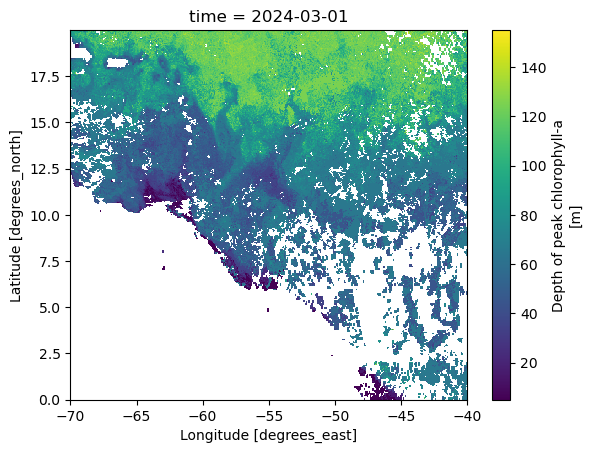

In [13]:
%%time
# Build a single virtual dataset from many NetCDFs
# (combine="by_coords" is usually the right default when time coords align)
ds_nc = xr.open_mfdataset(
    paths_v2[0:5],
    engine="h5netcdf",
    combine="by_coords",
    parallel=True,  # lets dask schedule per-file work
    chunks={},  # pick something reasonable for the demo
    backend_kwargs={"storage_options": {"token": "anon"}},  # important for gcs:// reads
)

roi = ds_nc["CHLA_peak_depth"].sel(lat=slice(20, 0), lon=slice(-70, -40))
m = roi.resample(time="MS").mean("time").compute()
m.isel(time=0).plot();

## Time series plot of monthly mean depth

I will show a time series of the monthly mean depth of the CHLA peak for a small region in the red box. I cannot really do this with the netcdfs since the `open_mfdataset()` step is onerous. We can see there is a clear seasonal pattern.

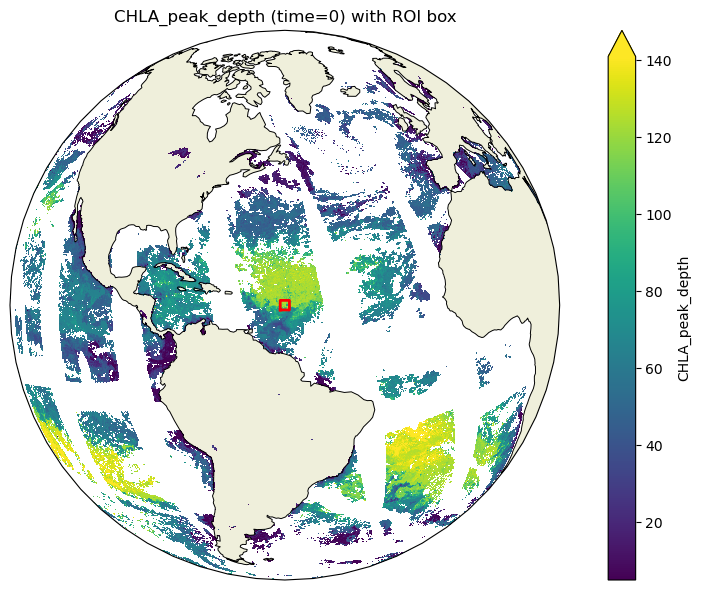

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import xarray as xr

zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})

# --- small ROI for time series ---
lat_small = (17, 15)
lon_small = (-55, -53)

# rectangle bounds (ensure min/max ordering)
lat_min, lat_max = sorted(lat_small)
lon_min, lon_max = sorted(lon_small)

# A "bigger area" map slice to plot (adjust padding as you like)
pad_lat = 12
pad_lon = 20
map_da = ds["CHLA_peak_depth"].isel(time=0).sel(
    lat=slice(lat_max + pad_lat, lat_min - pad_lat),
    lon=slice(lon_min - pad_lon, lon_max + pad_lon),
)
map_da = ds["CHLA_peak_depth"].isel(time=0).coarsen(lat=4, lon=4, boundary="trim").mean()

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(
    projection=ccrs.Orthographic(
        central_longitude=(lon_min + lon_max) / 2,
        central_latitude=(lat_min + lat_max) / 2,
    )
)

ax.set_global()
ax.add_feature(cfeature.LAND, linewidth=0)
ax.add_feature(cfeature.COASTLINE, linewidth=0.7)

# plot data (lon/lat grid -> PlateCarree)
map_da.plot(ax=ax, transform=ccrs.PlateCarree(), robust=True, add_colorbar=True)

# ROI box in red
xs = [lon_min, lon_max, lon_max, lon_min, lon_min]
ys = [lat_min, lat_min, lat_max, lat_max, lat_min]
ax.plot(xs, ys, transform=ccrs.PlateCarree(), linewidth=2, color="red")

ax.set_title("CHLA_peak_depth (time=0) with ROI box")
plt.tight_layout()
plt.show()


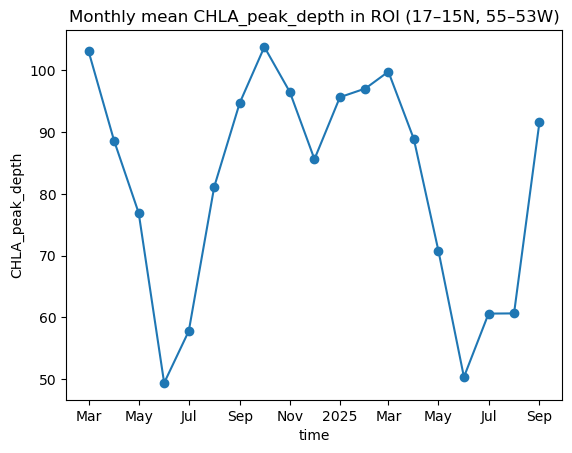

CPU times: user 2.37 s, sys: 246 ms, total: 2.62 s
Wall time: 3.36 s


In [32]:
%%time
import xarray as xr
import matplotlib.pyplot as plt

zarr_path = "gcs://nmfs_odp_nwfsc/CB/fish-pace-datasets/chla-z/zarr"
ds = xr.open_zarr(zarr_path, consolidated=False, storage_options={"token": "anon"})

da = ds["CHLA_peak_depth"]

# small region of interest
roi = da.sel(lat=slice(17, 15), lon=slice(-55, -53))

# monthly mean within ROI:
# 1) mean over space (lat/lon) for each timestep
# 2) resample to month starts and mean over time within each month
ts = roi.mean(("lat", "lon")).resample(time="MS").mean("time").compute()

# Plot
ts.plot(marker="o")
plt.title("Monthly mean CHLA_peak_depth in ROI (17–15N, 55–53W)")
plt.ylabel("CHLA_peak_depth")
plt.show()
